<a href="https://colab.research.google.com/github/PRomanVl/deep_learning_school/blob/main/Image_captionong/colab/Image_captionong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="left">Project - Image Captioning </h1>

Итоговый проект по курсу **Deep Learning** (часть 2, 2021) от команды Deep Learning School и ФПМИ МФТИ


## Описание

Image captioning - это задача генерации текстового описания для картинки. В данную задачу входит как и NLP, так и CV.

С изображениями лучше всего работают сверточные модели нейронных сетей CNN, а с текстом рекурентные RNN (или LSTM). Поэтому для создание модели, которая могла бы генерировать описание к картинкам, необходимо совместить оба этих подхода.

Для удобства задачу стоит разделить на две модели. Первая модель будет принимать изображение и выдавать векторное представление, вторая модель будет его принимать и генерировать текст. Вектор, по сути, это некоторое числовое "описание" изображения, в котором содержится вся необходимая информация для второй модели.

Данные для обучения необходимо в формате [изображение -> описание]. В проекте используется датасет MSCOCO ([описание](https://cocodataset.org/#download), [ссылка для скачивания](https://disk.yandex.ru/d/iK9ZtggjJcGKIA)). Для теста модели   изображения из
интернета.


### 1. Предобработка текстов из датасета

In [ ]:
import os
import pickle
from collections import Counter
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
import time

In [ ]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/image_captioning')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/image_captioning/'

Mounted at /content/gdrive


In [ ]:
!tar -xvf  './gdrive/My Drive/image_captioning/handout.tar'

data/
data/captions_tokenized.json
data/image_codes.npy


In [ ]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("/content/data/image_codes.npy")
captions = json.load(open('/content/data/captions_tokenized.json'))

In [ ]:
# смотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Необходимо сделать только следующее:

1. Добавить ко всем описаниям символы начала -bos- и конца предложения -eos-;
2. Посчитать частоту встречи каждого слова из словаря и оставить тольео те, которые больше Х раз упоминаются (например, Х=5);
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа;
4. Написать функцию, которая будет возвращать батч из описаний;
5. Поделить выборку на train/test.


In [ ]:
class Vocabulary(object):
  def __init__(self,
               vocab_threshold,
               vocab_file='/content/data/vocab.pkl',
               start_word='<bos>',
               end_word='<eos>',
               pad_word='<pad>',
               unk_word='<unk>',
               path_tokenized_file='/content/data/captions_tokenized.json',
               vocab_from_file=False):

      ''' Инициализация парамметров словаря.

          Параметры:
          vocab_threshold: Минимальное количество слов для добавления в словарь
                           слова.
          vocab_file: Файл со словарем.
          start_word: Специальный символ для указания начала в предложении.
          end_word: Специальный символ для указания конца в предложении.
          pad_word: Специальный символ для указания пропуска в предложении.
          unk_word: Специальный символ для указания неизвестного слова
                    в предложении.
          capt_tokenized_file: Путь до токенизированных данных.
          vocab_from_file: Если False, то создает словарь и записывает его
                           в vocab_file. Если True, то подгружает его из
                           vocab_file если он существует.
      '''
      self.vocab_threshold = vocab_threshold
      self.vocab_file = vocab_file
      self.start_word = start_word
      self.end_word = end_word
      self.pad_word = pad_word
      self.unk_word = unk_word
      self.path_tokenized_file = path_tokenized_file
      self.vocab_from_file = vocab_from_file
      self.get_vocab()

  def get_vocab(self):
      '''Загружает файл словаря или создает его и сохраняет'''
      if os.path.exists(self.vocab_file) & self.vocab_from_file:
          with open(self.vocab_file, "rb") as f:
              vocab = pickle.load(f)
              self.word2idx = vocab.word2idx
              self.idx2word = vocab.idx2word
              print("Vocabulary successfully loaded from vocab.pkl file!")
      else:
          self.build_vocab()
          with open(self.vocab_file, "wb") as f:
              pickle.dump(self, f)

  def build_vocab(self):
      '''Создание словаря и наполнение его словами'''
      self.init_vocab()
      self.add_word(self.unk_word)
      self.add_word(self.start_word)
      self.add_word(self.end_word)
      self.add_word(self.pad_word)
      self.add_captions()

  def init_vocab(self):
      '''Инициализация словаря'''
      self.word2idx = {}
      self.idx2word = {}
      self.idx = 0

  def add_word(self, word):
      '''Добавление токена и количества в словарь'''
      if not word in self.word2idx:
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
          self.idx += 1

  def add_captions(self):
      '''Цикл для добавления слов из всего текста в словарь с ограничением по
         количеству слов'''
      captions = json.load(open(self.path_tokenized_file))
      counter = Counter()

      for img_i in range(len(captions)):
          for caption_i in range(len(captions[img_i])):
              sentence = captions[img_i][caption_i]
              counter.update(sentence.split(' '))

          if img_i % 50000 == 0:
              print("[%d/%d] Building vocab..." % (img_i, len(captions)))

      print('[%d/%d] Finish!' % (len(captions), len(captions)))

      words = [word for word, count in counter.items()
               if count >= self.vocab_threshold]

      for i, word in enumerate(words):
          self.add_word(word)

  def get_idx(self, word):
      if not word in self.word2idx:
          return self.word2idx[self.unk_word]
      return self.word2idx[word]

  def get_word(self, idx):
      if not idx in self.idx2word:
          return self.unk_word
      return self.idx2word[idx]

  def __len__(self):
      return len(self.word2idx)

vocab = Vocabulary(vocab_threshold=5)

[0/118287] Building vocab...
[50000/118287] Building vocab...
[100000/118287] Building vocab...
[118287/118287] Finish!


Пример работы словаря:

In [ ]:
sample_caption = 'large piles of carrots and potatoes at a crowded outdoor market .'
sample_result = []

sample_result.append(vocab.get_idx('<bos>'))
sample_result.extend([vocab.get_idx(token) for token in sample_caption.split(' ')])
sample_result.append(vocab.get_idx('<eos>'))

print(sample_caption)
print(sample_result)

sample_caption = 'people shop for vegetables like carrots and potatoes at an open air market .'
sample_result = []

sample_result.append(vocab.get_idx('<bos>'))
sample_result.extend([vocab.get_idx(token) for token in sample_caption.split(' ')])
sample_result.append(vocab.get_idx('<eos>'))

print('')
print(sample_caption)
print(sample_result)

large piles of carrots and potatoes at a crowded outdoor market .
[1, 21, 16, 14, 22, 15, 23, 18, 24, 25, 26, 9, 12, 2]

people shop for vegetables like carrots and potatoes at an open air market .
[1, 4, 27, 10, 11, 28, 22, 15, 23, 18, 7, 8, 19, 9, 12, 2]


In [ ]:
class BatchIterator():
    def __init__(self,
                 img_codes,
                 captions,
                 vocab,
                 batch_size=32,
                 shuffle=True,
                 device=torch.device('cpu')):

        ''' Инициализация иттератора батчей.

            Параметры:
            img_codes: Данные с векторами картинок.
            captions: Данные с описаниями картинок.
            vocab: Словарь слов и их коды
            batch_size: Размер батча на выходе
            shuffle: Флаг для перемешивания выборки
            device: Использование cpu/gpu
        '''
        self.img_codes = img_codes
        self.img_size = img_codes.shape[1]
        self.captions = captions
        self.num_samples = len(captions)
        self.vocab = vocab
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.device = device

    def __len__(self):
        return self.batches_count

    def max_length_caption(self, batch):
        '''Подсчет максимальной длинны предложений в батче'''
        max_lenght = 0

        for caption in batch:
            if len(caption) > max_lenght:
              max_lenght = len(caption)

        return max_lenght

    def __iter__(self):
        '''Функция позволяющая иттерироваться по батчам'''
        indices = np.arange(self.num_samples) # TODO: Учетом нескольких описаний к одной картинке

        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_image = []
            batch_caption = []

            for img_idx in batch_indices:
                # Берем описания для img_idx-картинки
                image_captions = self.captions[img_idx]
                # Генерируем случайно число для выбора одного описания
                capt_ind = np.random.randint(0, len(image_captions))

                # Добавляем к предложению спец. симв. и токенизируем его
                caption = []
                caption.append(self.vocab.get_idx(self.vocab.start_word))
                caption.extend([self.vocab.get_idx(token) for token in image_captions[capt_ind].split(' ')])
                caption.append(self.vocab.get_idx(self.vocab.end_word))

                # Наполняем батчи
                batch_image.append(self.img_codes[img_idx])
                batch_caption.append(caption)

            # Ищем максимальную длину предложения в батче
            # и дополняем остальные <pad>-ми до этого размера
            max_length = self.max_length_caption(batch_caption)
            for i, caption in enumerate(batch_caption):
                batch_caption[i] = caption + [self.vocab.get_idx(self.vocab.pad_word)] * (max_length - len(caption))

            # Оборачиваем в тензоры
            tensor_image = torch.zeros((self.batch_size, self.img_size), dtype=torch.float32, device=self.device)
            tensor_caption = torch.zeros((self.batch_size, max_length), dtype=torch.int64, device=self.device)

            for i, iamges in enumerate(batch_image):
                tensor_image[i][:len(iamges)] = torch.FloatTensor(iamges)

            for i, captions in enumerate(batch_caption):
                tensor_caption[i][:len(captions)] = torch.IntTensor(captions)

            yield {
                'images': tensor_image,
                'captions': tensor_caption,
            }

Пример работы батч-иттератора:

In [ ]:
train_iterator = BatchIterator(img_codes, captions, vocab, 4)

for batch in train_iterator:
    print('Image vector:', batch['images'].shape)
    print(batch['images'][0], '\n')
    print('Caption vector:', batch['captions'].shape)
    print(batch['captions'][0], '\n')
    print('Caption text:', [vocab.get_word(idx.item()) for idx in batch['captions'][0]])
    break

Image vector: torch.Size([4, 2048])
tensor([0.3748, 0.2833, 0.2295,  ..., 0.0872, 0.1128, 0.3452]) 

Caption vector: torch.Size([4, 16])
tensor([   1,   24,   57, 1956,   24,  102,   14, 1025,   15,   24,  189,   58,
          73,  612,   12,    2]) 

Caption text: ['<bos>', 'a', 'man', 'takes', 'a', 'picture', 'of', 'himself', 'and', 'a', 'baby', 'with', 'his', 'phone', '.', '<eos>']


Разбиваем выборку на train, test, valid (60/30/10) и добавляем для них иттериуемые переменные.

In [ ]:
def train_test_split(images, captions, train_size=0.9, valid_size=0.1, shuffle=True):
    train_shape = int(np.floor(images.shape[0] * train_size))
    valid_shape = int(np.floor(images.shape[0] * valid_size))

    if images.shape[0] != sum([train_shape, valid_shape]):
        last = images.shape[0] - sum([train_shape, valid_shape])
        train_shape += last

    print('All data shape', images.shape[0])
    print('-------------------------------')
    print('Train shape -', train_shape)
    print('Valid shape -', valid_shape)

    train_indices = np.arange(train_shape)
    print(train_indices)
    valid_indices = np.arange(valid_shape)
    print(valid_indices)
    if shuffle:
        np.random.shuffle(train_indices)
        np.random.shuffle(valid_indices)

    images_train = np.array(images)[train_indices]
    captions_train = np.array(captions)[train_indices]

    images_val = np.array(images)[valid_indices]
    captions_val = np.array(captions)[valid_indices]

    return images_train, captions_train, images_val, captions_val, train_shape, valid_shape

img_train, capt_train, img_val, capt_val, train_size, valid_size = train_test_split(img_codes, captions)

All data shape 118287
-------------------------------
Train shape - 106459
Valid shape - 11828
[     0      1      2 ... 106456 106457 106458]
[    0     1     2 ... 11825 11826 11827]


In [ ]:
print(img_train[0])
print(capt_train[0])

[0.18516855 0.09969298 0.4679725  ... 0.01712141 0.46019828 1.4180145 ]
['a group of sheep graze in a grassy field .'
 'a bunch of sheep doing different things in a field'
 'several sheep in a field on either side of an open gate .'
 'a number of sheep in grass near a wooden fence .'
 'a bunch of sheep that are eating on some grass']


In [ ]:
print(img_val[0])
print(capt_val[0])

[0.24065852 0.13313955 0.07950296 ... 0.11520337 0.01040843 0.00062246]
['a brick clock tower stands in the middle of a colorful flower garden .'
 'a large brick clock tower standing in the middle of lots of flowers .'
 'a roundabout with a clock tower and various flowers around it .'
 'a clock tower in the middle of patches of flowers in the city'
 'a clock atop a stone structure in the middle of a garden of flowers .']


In [ ]:
train_iterator = BatchIterator(img_train, capt_train, vocab, 10)
valid_iterator = BatchIterator(img_val, capt_val, vocab, 10)

In [ ]:
len(train_iterator)

AttributeError: ignored

In [ ]:
for i in train_iterator:
    print(i)

### 2. Напишем свою сетку из RNN для вывода описаний

![img](https://github.com/yunjey/pytorch-tutorial/raw/master/tutorials/03-advanced/image_captioning/png/model.png)


Добавим RNN сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [ ]:
class CaptionDecoderRNN(nn.Module):
    def __init__(self,
                 embed_size,
                 hidden_size,
                 vocab_size,
                 cnn_feature_size=2048,
                 num_layers=2):
        super(self.__class__, self).__init__()

        ''' Декодер для описания изображения (вектора представления)

            Параметры:
            embed_size: Размер эмбединга
            hidden_size: Размер скрытого слоя
            vocab_size: Размер словаря
            cnn_feature_size: Размер выходного вектора
            num_layers: Количество слоев
        '''

        # стандартная архитектура такой сети такая:
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов
        self.num_layers=num_layers

        self.img_to_h0 = nn.Linear(cnn_feature_size, hidden_size)
        self.img_to_h0 = nn.Linear(cnn_feature_size, hidden_size)
        self.tanh = nn.Tanh()
        # self.dropout = nn.Dropout(p=0.2)

        self.emb = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        self.logits = nn.Linear(hidden_size, vocab_size)


    def forward(self, image_vectors, captions):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor, содержащий выходы inseption.
               shape: [batch_size, cnn_feature_size]

        :param captions_idx: таргет описания картинок в виде матрицы
               shape: [batch_size, word_i]

        :returns: outputs: логиты для сгенерированного текста описания
                  shape: [batch_size, word_i, p_vocab_i]
        """
        # 1. инициализируем LSTM state
        # [batch_size, hidden_size]
        h0 = self.tanh(self.img_to_h0(image_vectors))
        c0 = self.tanh(self.img_to_h0(image_vectors))

        # make [num_layer, batch_size, hidden_size]
        h0 = h0.expand(self.num_layers, h0.size(0), h0.size(1)).contiguous()
        c0 = c0.expand(self.num_layers, c0.size(0), c0.size(1)).contiguous()

        # 2. применим слой эмбеддингов к captions
        # [batch_size, max_len, emb_size]
        captions_emb = self.emb(captions)

        # 3. кормим LSTM captions_emb и добавим скрытые веса картинки
        # [batch_size, max_len, hidden_size]
        hiddens, _ = self.lstm(captions_emb, (h0, c0))

        # 4. посчитаем логиты из выхода LSTM
        # [batch_size, max_len, vocab_size]
        logits = self.logits(hiddens)

        return logits

### 3. Train

In [ ]:
def train_model(model, train_iterator, valid_iterator, vocablurary,
                batch_size=32, n_batches_per_epoch=32, n_validation_batches=5,
                n_epochs=1, device='cpu'):

    params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Trainable params: {}'.format(params_count))
    print('-----------------------------------------')

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.get_idx('<pad>')).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-8)

    best_val_loss = 1000
    avg_train_loss = []
    avg_val_loss = []
    start_time = time.time()

    for epoch in range(n_epochs):
      # Training part
      train_loss = 0
      model.train(True)
      for i, batch in enumerate(train_iterator):
        images = batch['images'].to(device)
        captions_ix_inp = batch['captions'][:, :-1].contiguous().to(device)
        captions_ix_next = batch['captions'][:, 1:].contiguous().to(device)

        optimizer.zero_grad()
        logits = model(images, captions_ix_inp)

        loss = criterion(logits.view(-1, logits.shape[2]), captions_ix_next.view(-1))

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

      train_loss /= n_batches_per_epoch
      avg_train_loss.append(train_loss)

      # Validation part
      val_loss = 0
      sample_per_batch = True
      model.train(False)
      for _, batch in enumerate(valid_iterator):
        images = batch['images'].to(device)
        captions_ix_inp = batch['captions'][:, :-1].contiguous().to(device)
        captions_ix_next = batch['captions'][:, 1:].contiguous().to(device)

        logits = model(images, captions_ix_inp)
        loss = criterion(logits.view(-1, logits.shape[2]), captions_ix_next.view(-1))

        val_loss += loss.item()

        # На каждой эпохе смотрим как модель генерирует описание для изображения
        # на валидационной части
        if sample_per_batch:
            sample_per_batch = False
            sample_image = batch['images'][0].unsqueeze(0).to(device)
            sample_caption = batch['captions'][0].unsqueeze(0).to(device)

            original_sentence = [vocab.get_word(idx.item()) for idx in sample_caption[0][1:]]
            print('Original:', original_sentence)

            logits = model(sample_image, sample_caption)
            scores = F.softmax(logits.cpu(), -1).data.numpy()[0]
            scores = scores ** 5 / np.sum(scores ** 5)
            generated_sentence = [vocab.get_word(score) for score in np.argmax(scores, -1)]
            print('Generated:', generated_sentence)

      val_loss /= n_validation_batches
      avg_val_loss.append(val_loss)

      # Сохранение лучшей модели по лоссу на валидации
      # (хотя бы так, но не самый лучший вариант, т.к лучше использовать bleu)
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_model_base.ckpt')

      print("\nEpoch = {}, Avg Train Loss = {:.4f}, Avg Val Loss = {:.4f}, Best Val Loss = {:.4f}, Time = {:.2f}s\n" \
            .format(epoch+1, np.mean(avg_train_loss), np.mean(avg_val_loss),
                    best_val_loss, time.time() - start_time))
      start_time = time.time()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_epochs = 25
batch_size = 50
n_batches_per_epoch = np.floor(train_size / batch_size)
batch_valid_size = 25
n_validation_batches = np.floor(valid_size / batch_valid_size)
lstm_num_layers = 4

train_iterator = BatchIterator(img_train, capt_train, vocab, batch_size)
valid_iterator = BatchIterator(img_val, capt_val, vocab, batch_size)

model = CaptionDecoderRNN(embed_size=300,
                          hidden_size=512,
                          vocab_size=len(vocab),
                          cnn_feature_size=img_codes.shape[1],
                          num_layers=lstm_num_layers)

train_model(model, train_iterator, valid_iterator, vocab, batch_size,
            n_batches_per_epoch, n_validation_batches, n_epochs, device)

### 4. Inseption и получение результатов

Для получения векторного представления по заданию проекта было предложенно взять уже обученную модель сети Inception

In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/master/homework04/beheaded_inception3.py

--2021-02-07 08:49:10--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/master/homework04/beheaded_inception3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1811 (1.8K) [text/plain]
Saving to: ‘beheaded_inception3.py’

beheaded_inception3 100%[===================>]   1.77K  --.-KB/s    in 0s      

2021-02-07 08:49:11 (32.0 MB/s) - ‘beheaded_inception3.py’ saved [1811/1811]



In [ ]:
# Загружаем inseption, чтобы можно было прогонять через него новые картинки,
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



### 5. Сгенерируем описание

In [ ]:
def generate_caption(image, t=5, max_len=100, device='cpu'):
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

    vectors_8x8, vectors_neck, logits = inception(image[None])
    captions_prefix = ['<bos>']

    for _ in range(max_len):
        # Получаем коды слов из словаря
        captions_ix = [vocab.get_idx(word) for word in captions_prefix]
        # Оборачиваем в торч тензор
        captions_ix = torch.tensor(captions_ix, dtype=torch.int64, device=device)

        # Получаем логиты следующего слова
        next_word_logits = model.forward(vectors_neck.to(device), captions_ix.unsqueeze(0))[0, -1]
        # Преобразуем их в вероятности
        next_word_probs = F.softmax(next_word_logits.cpu(), -1).data.numpy()

        assert len(next_word_probs.shape) == 1

        # Не совсем понял что это, но в домашки ШАДа это было.
        # Видимо очень важно и нужно!
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t)

        # Получаем слово в исходном виде
        next_word = vocab.get_word(np.argmax(next_word_probs).item())

        # Добавляем его к предложению
        captions_prefix.append(next_word)

        # Если сгенерировалось конец предложения, то останавливаем процесс
        if next_word == '<eos>':
            break

    return captions_prefix

### 6. Скачаем пару картинок, чтобы проверить качество:

--2021-02-07 08:52:43--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-02-07 08:52:43--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.007s  

2021-02-07 08:52:43 (7.32 MB/s) - ‘img.jpg’ saved [54731

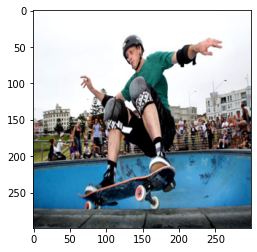

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
for i in range(1):
    print(' '.join(generate_caption(img, t=5, device=device)[1:-1]))

--2021-02-07 08:52:44--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 146.20.65.28
Connecting to ccanimalclinic.com (ccanimalclinic.com)|146.20.65.28|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-02-07 08:52:44--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|146.20.65.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   610KB/s    in 0.2s    

2021-02-07 08:52:44 (610 KB/s) - ‘img.jpg’ saved [106870/106870]



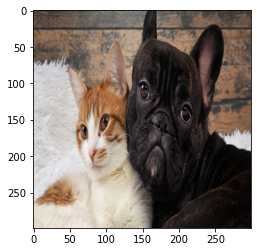

a cat laying on a couch next to a remote control .


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 08:52:45--  https://cdn24.img.ria.ru/images/07e4/0c/0e/1589194827_0:59:1104:680_1920x0_80_0_0_3f4218180b4fde9c91e16475a7c8151a.jpg
Resolving cdn24.img.ria.ru (cdn24.img.ria.ru)... 151.236.86.143
Connecting to cdn24.img.ria.ru (cdn24.img.ria.ru)|151.236.86.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 259019 (253K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 252.95K   556KB/s    in 0.5s    

2021-02-07 08:52:47 (556 KB/s) - ‘img.jpg’ saved [259019/259019]



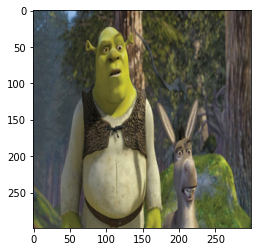

a man is holding an umbrella while standing in a room .


In [ ]:
!wget https://cdn24.img.ria.ru/images/07e4/0c/0e/1589194827_0:59:1104:680_1920x0_80_0_0_3f4218180b4fde9c91e16475a7c8151a.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 08:52:47--  https://s0.rbk.ru/v6_top_pics/media/img/2/35/755959464235352.jpg
Resolving s0.rbk.ru (s0.rbk.ru)... 80.68.253.2, 185.72.229.2
Connecting to s0.rbk.ru (s0.rbk.ru)|80.68.253.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 784347 (766K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 765.96K   314KB/s    in 2.4s    

2021-02-07 08:52:51 (314 KB/s) - ‘img.jpg’ saved [784347/784347]



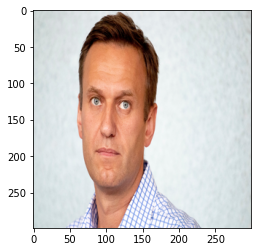

a man in a suit and tie holding a plate of food .


In [ ]:
!wget https://s0.rbk.ru/v6_top_pics/media/img/2/35/755959464235352.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 08:52:51--  http://www.mirorenzaglia.org/wp-content/uploads/2008/09/putin-man-boobs-fishing.jpg
Resolving www.mirorenzaglia.org (www.mirorenzaglia.org)... 37.187.156.158
Connecting to www.mirorenzaglia.org (www.mirorenzaglia.org)|37.187.156.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23076 (23K) [image/jpeg]
Saving to: ‘putin.jpg’

putin.jpg           100%[===================>]  22.54K  --.-KB/s    in 0.1s    

2021-02-07 08:52:52 (162 KB/s) - ‘putin.jpg’ saved [23076/23076]



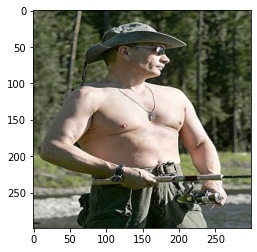

a man in a red shirt and black pants stands on a skateboard .


In [ ]:
!wget http://www.mirorenzaglia.org/wp-content/uploads/2008/09/putin-man-boobs-fishing.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 08:52:53--  https://100dorog.ru/upload/images/articles/2014/6572886-21-Babochki_i.jpg
Resolving 100dorog.ru (100dorog.ru)... 78.46.79.246
Connecting to 100dorog.ru (100dorog.ru)|78.46.79.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39302 (38K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  38.38K  --.-KB/s    in 0.1s    

2021-02-07 08:52:54 (266 KB/s) - ‘img.jpg’ saved [39302/39302]



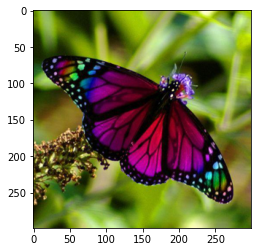

a small bird is standing on a rock


In [ ]:
!wget https://100dorog.ru/upload/images/articles/2014/6572886-21-Babochki_i.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 08:52:55--  https://games.mail.ru/pre_0x736_resize/hotbox/content_files/news/2018/10/3b196c5.jpeg?quality=85
Resolving games.mail.ru (games.mail.ru)... 178.22.89.40
Connecting to games.mail.ru (games.mail.ru)|178.22.89.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54156 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  52.89K   292KB/s    in 0.2s    

2021-02-07 08:52:56 (292 KB/s) - ‘img.jpg’ saved [54156/54156]



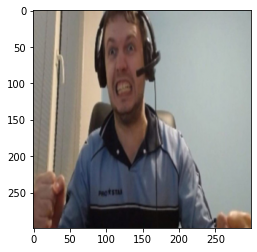

a man in a suit and tie is looking at a camera .


In [ ]:
!wget https://games.mail.ru/pre_0x736_resize/hotbox/content_files/news/2018/10/3b196c5.jpeg?quality=85 -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 08:53:01--  https://i0.wp.com/arts-dnevnik.ru/wp-content/uploads/2017/11/7CF64A76-D4A9-4D0F-9A69-1F7E815E484B.jpeg
Resolving i0.wp.com (i0.wp.com)... 192.0.77.2
Connecting to i0.wp.com (i0.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258656 (253K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 252.59K  --.-KB/s    in 0.1s    

2021-02-07 08:53:01 (2.29 MB/s) - ‘img.jpg’ saved [258656/258656]



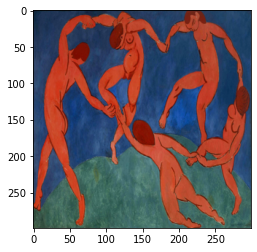

a group of people on a beach with a kite .


In [ ]:
!wget https://i0.wp.com/arts-dnevnik.ru/wp-content/uploads/2017/11/7CF64A76-D4A9-4D0F-9A69-1F7E815E484B.jpeg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

## Дополнительно: Attention

В качестве бонусного задания предлагалось реализовать механизм attention в rnn-сети из базовой части.



### 1. Архитектура

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_size, hidden_size):
        super(Attention, self).__init__()

        self.U = nn.Linear(hidden_size, hidden_size)
        self.W = nn.Linear(enc_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()
        self.sofmax = nn.Softmax(1)

    def forward(self, img_features, hidden_state):
        """
        Apply the attention module to Decoder.
        Article - https://arxiv.org/pdf/1502.03044.pdf

        :param image_vectors: torch tensor, содержащий выходы inseption.
               shape: [batch_size, cnn_feature_size]

        :param hidden_state: torch tensor, initial hidden state in LSTM
               shape: [batch_size, max_len]

        :returns: context: torch tensor, a dynamic representation of the
                           relevant part of the image input at time t
                  shape: [batch_size, cnn_feature_size]

        :returns: alpha: torch tenosr, the weight alpha_i of each annotation
                         vector a_i.
                  shape: [batch_size, batch_size]
        """

        U_h = self.U(hidden_state).unsqueeze(1)
        W_s = self.W(img_features)
        attn = self.tanh(W_s + U_h)
        e = self.v(attn).squeeze(2) # formula (4)
        alpha = self.sofmax(e) # formula (5)
        context = (img_features * alpha.unsqueeze(2)).sum(1) # formula (9)

        return context, alpha

In [ ]:
class CaptionDecoderAttnRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, cnn_feature_size=2048, tf=False):
        super(self.__class__, self).__init__()
        self.use_teacher_forcing = tf
        self.vocab_size = vocab_size
        self.dropout = nn.Dropout(p=0.5) # Необходим для teacher_forcing

        self.img_to_h0 = nn.Linear(cnn_feature_size, hidden_size)
        self.img_to_h0 = nn.Linear(cnn_feature_size, hidden_size)
        self.f_beta = nn.Linear(hidden_size, cnn_feature_size)
        self.logits = nn.Linear(hidden_size, vocab_size)

        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

        self.emb = nn.Embedding(vocab_size, hidden_size)
        self.attn = Attention(cnn_feature_size, hidden_size)
        self.lstm = nn.LSTMCell(hidden_size + cnn_feature_size, hidden_size)

    def forward(self, image_vectors, captions):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor, содержащий выходы inseption.
               shape: [batch_size, cnn_feature_size]

        :param captions_idx: torch tensor, таргет описания картинок в виде матрицы
               shape: [batch_size, max_len]

        :returns: preds: torch tensor, предикты для каждого слова
                  shape: [batch_size, max_len, vocab_size]

        :returns: alphas: the weight alpha_i of each annotation vector a_i.
                  shape: [batch_size, max_len, batch_size]
        """
        batch_size = image_vectors.size(0)
        max_timespan = captions.size(1)

        # [batch_size, hidden_size]
        h = self.tanh(self.img_to_h0(image_vectors))
        c = self.tanh(self.img_to_h0(image_vectors))

        prev_words = torch.zeros(batch_size, 1, dtype=torch.int64, device=image_vectors.device)

        if self.use_teacher_forcing:
            embedding = self.emb(captions) if self.training else self.emb(prev_words)
        else:
            embedding = self.emb(prev_words)

        preds = torch.zeros(batch_size, max_timespan, self.vocab_size, device=image_vectors.device)
        alphas = torch.zeros(batch_size, max_timespan, image_vectors.size(0), device=image_vectors.device)

        for t in range(max_timespan):
            context, alpha = self.attn(image_vectors, h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            if self.use_teacher_forcing and self.training:
                lstm_input = torch.cat((embedding[:, t], gated_context), dim=1)
            else:
                embedding = embedding.squeeze(1) if embedding.dim() == 3 else embedding
                lstm_input = torch.cat((embedding, gated_context), 1)

            h, c = self.lstm(lstm_input, (h, c))

            logit = self.logits(self.dropout(h))

            preds[:, t] = logit
            alphas[:, t] = alpha

            if not self.training or not self.use_teacher_forcing:
                embedding = self.emb(logit.max(1)[1].reshape(batch_size, 1))

        return preds, alphas

### 2. Train

In [ ]:
def train_model(model, train_iterator, valid_iterator, vocablurary,
                batch_size=32, n_batches_per_epoch=32, n_validation_batches=5,
                n_epochs=1, device='cpu', alpha_c=0.1):

    params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Trainable params: {}'.format(params_count))
    print('-----------------------------------------')

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.get_idx('<pad>')).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-8)

    best_val_loss = 1000
    avg_train_loss = []
    avg_val_loss = []
    start_time = time.time()

    for epoch in range(n_epochs):
      # Training part
      train_loss = 0
      model.train(True)
      for i, batch in enumerate(train_iterator):
        images = batch['images'].to(device)
        captions_ix_inp = batch['captions'][:, :-1].contiguous().to(device)
        captions_ix_next = batch['captions'][:, 1:].contiguous().to(device)

        optimizer.zero_grad()
        logits, alphas = model(images, captions_ix_inp)

        # Добавим также в рассчет лосса еще и немного значения для атеншена
        att_regularization = alpha_c * ((1 - alphas.sum(1)) ** 2).mean()
        loss = criterion(logits.view(-1, logits.shape[2]), captions_ix_next.view(-1))

        loss += att_regularization

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

      train_loss /= n_batches_per_epoch
      avg_train_loss.append(train_loss)

      # Validation part
      val_loss = 0
      sample_per_batch = True
      model.train(False)
      for _, batch in enumerate(valid_iterator):
        images = batch['images'].to(device)
        captions_ix_inp = batch['captions'][:, :-1].contiguous().to(device)
        captions_ix_next = batch['captions'][:, 1:].contiguous().to(device)

        logits, alphas = model(images, captions_ix_inp)
        att_regularization = alpha_c * ((1 - alphas.sum(1))**2).mean()

        loss = criterion(logits.view(-1, logits.shape[2]), captions_ix_next.view(-1))
        loss += att_regularization

        val_loss += loss.item()

        # На каждой эпохе смотрим как модель генерирует описание для изображения
        # на валидационной части
        if sample_per_batch:
            sample_per_batch = False
            sample_image = batch['images'][0].unsqueeze(0).to(device)
            sample_caption = batch['captions'][0].unsqueeze(0).to(device)

            original_sentence = [vocab.get_word(idx.item()) for idx in sample_caption[0][1:]]
            print('Original:', original_sentence)

            logits, alphas = model(sample_image, sample_caption)
            scores = F.softmax(logits.cpu(), -1).data.numpy()[0]
            scores = scores ** 5 / np.sum(scores ** 5)
            generated_sentence = [vocab.get_word(score) for score in np.argmax(scores, -1)]
            print('Generated:', generated_sentence)

      val_loss /= n_validation_batches
      avg_val_loss.append(val_loss)

      # Сохранение лучшей модели по лоссу на валидации
      # (хотя бы так, но не самый лучший вариант, т.к лучше использовать bleu)
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_model_attn.ckpt')

      print("\nEpoch = {}, Avg Train Loss = {:.4f}, Avg Val Loss = {:.4f}, Best Val Loss = {:.4f}, Time = {:.2f}s\n" \
            .format(epoch+1, np.mean(avg_train_loss), np.mean(avg_val_loss),
                    best_val_loss, time.time() - start_time))
      start_time = time.time()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_epochs = 15
batch_size = 32
n_batches_per_epoch = np.floor(train_size / batch_size)
batch_valid_size = 25
n_validation_batches = np.floor(valid_size / batch_valid_size)
lstm_num_layers = 4

train_iterator = BatchIterator(img_train, capt_train, vocab, batch_size)
valid_iterator = BatchIterator(img_val, capt_val, vocab, batch_valid_size)

model = CaptionDecoderAttnRNN(hidden_size=512,
                              vocab_size=len(vocab),
                              cnn_feature_size=img_codes.shape[1],
                              tf=True)

train_model(model, train_iterator, valid_iterator, vocab, batch_size,
            n_batches_per_epoch, n_validation_batches, n_epochs, device)

Trainable params: 20370596
-----------------------------------------
Original: ['a', 'boat', 'going', 'a', 'high', 'speed', 'on', 'a', 'river', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Generated: ['a', 'man', 'riding', 'a', 'wave', 'on', 'a', 'surfboard', '.', '<eos>', '.', '<eos>', '.', '<eos>', '.', '<eos>', '.', '<eos>']

Epoch = 1, Avg Train Loss = 3.3923, Avg Val Loss = 7.2930, Best Val Loss = 7.2930, Time = 228.00s

Original: ['a', 'bed', 'in', 'a', 'hotel', 'room', 'with', 'checkered', 'purple', 'sheets', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Generated: ['a', 'bed', 'with', 'a', 'bed', 'and', 'a', 'window', '.', '<eos>', '<eos>', '.', '<eos>', '<eos>', '.', '<eos>', '<eos>', '.', '<eos>']

Epoch = 2, Avg Train Loss = 3.1613, Avg Val Loss = 7.4558, Best Val Loss = 7.2930, Time = 229.54s

Original: ['a', 'train', 'on', 'some', 'tracks', 'near', 'a', 'station', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

### Проверка

Делаем тоже самое, что и на одном из прошлых шагов. Загружаем картинку и делаем к ней описание.

In [ ]:
def generate_caption(image, t=5, max_len=100, device='cpu'):
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

    vectors_8x8, vectors_neck, logits = inception(image[None])
    captions_prefix = ['<bos>']

    for _ in range(max_len):
        # Получаем коды слов из словаря
        captions_ix = [vocab.get_idx(word) for word in captions_prefix]
        # Оборачиваем в торч тензор
        captions_ix = torch.tensor(captions_ix, dtype=torch.int64, device=device)

        # Получаем логиты следующего слова
        next_word_logits, alphas = model.forward(vectors_neck.to(device), captions_ix.unsqueeze(0))
        # Преобразуем их в вероятности
        next_word_probs = F.softmax(next_word_logits[0, -1].cpu(), -1).data.numpy()

        assert len(next_word_probs.shape) == 1

        # Не совсем понял что это, но в домашки ШАДа это было.
        # Видимо очень важно и нужно!
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t)

        # Получаем слово в исходном виде
        next_word = vocab.get_word(np.argmax(next_word_probs).item())

        # Добавляем его к предложению
        captions_prefix.append(next_word)

        # Если сгенерировалось конец предложения, то останавливаем процесс
        if next_word == '<eos>':
            break

    return captions_prefix

--2021-02-07 10:01:12--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-02-07 10:01:12--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.007s  

2021-02-07 10:01:12 (7.02 MB/s) - ‘img.jpg’ saved [54731

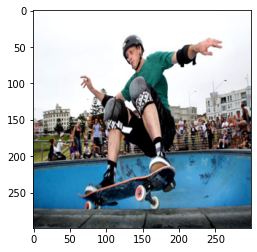

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline

!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
for i in range(1):
    print(' '.join(generate_caption(img, t=5, device=device)[1:-1]))

--2021-02-07 10:01:13--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 146.20.65.28
Connecting to ccanimalclinic.com (ccanimalclinic.com)|146.20.65.28|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-02-07 10:01:13--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|146.20.65.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   553KB/s    in 0.2s    

2021-02-07 10:01:14 (553 KB/s) - ‘img.jpg’ saved [106870/106870]



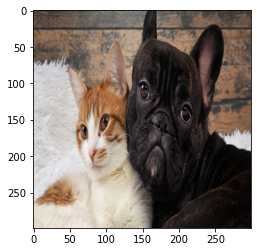

a cat laying on a couch with a cat on it .


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 10:01:14--  https://cdn24.img.ria.ru/images/07e4/0c/0e/1589194827_0:59:1104:680_1920x0_80_0_0_3f4218180b4fde9c91e16475a7c8151a.jpg
Resolving cdn24.img.ria.ru (cdn24.img.ria.ru)... 151.236.90.79
Connecting to cdn24.img.ria.ru (cdn24.img.ria.ru)|151.236.90.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 259019 (253K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 252.95K   560KB/s    in 0.5s    

2021-02-07 10:01:16 (560 KB/s) - ‘img.jpg’ saved [259019/259019]



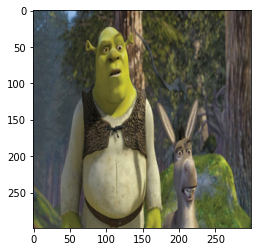

a man holding a cell phone in his hand .


In [ ]:
!wget https://cdn24.img.ria.ru/images/07e4/0c/0e/1589194827_0:59:1104:680_1920x0_80_0_0_3f4218180b4fde9c91e16475a7c8151a.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 10:01:17--  https://s0.rbk.ru/v6_top_pics/media/img/2/35/755959464235352.jpg
Resolving s0.rbk.ru (s0.rbk.ru)... 80.68.253.2, 185.72.229.2
Connecting to s0.rbk.ru (s0.rbk.ru)|80.68.253.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 784347 (766K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 765.96K   338KB/s    in 2.3s    

2021-02-07 10:01:20 (338 KB/s) - ‘img.jpg’ saved [784347/784347]



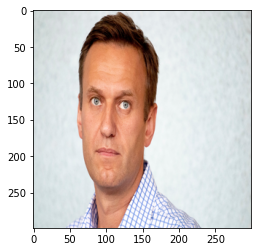

a man holding a cell phone in his hand .


In [ ]:
!wget https://s0.rbk.ru/v6_top_pics/media/img/2/35/755959464235352.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 10:01:21--  http://www.mirorenzaglia.org/wp-content/uploads/2008/09/putin-man-boobs-fishing.jpg
Resolving www.mirorenzaglia.org (www.mirorenzaglia.org)... 37.187.156.158
Connecting to www.mirorenzaglia.org (www.mirorenzaglia.org)|37.187.156.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23076 (23K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  22.54K  --.-KB/s    in 0.1s    

2021-02-07 10:01:21 (168 KB/s) - ‘img.jpg’ saved [23076/23076]



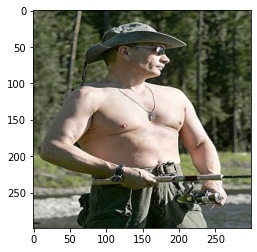

a man is holding a cell phone in his hand .


In [ ]:
!wget http://www.mirorenzaglia.org/wp-content/uploads/2008/09/putin-man-boobs-fishing.jpg -O img.jpg
img = plt.imread('putin.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 10:01:22--  https://100dorog.ru/upload/images/articles/2014/6572886-21-Babochki_i.jpg
Resolving 100dorog.ru (100dorog.ru)... 78.46.79.246
Connecting to 100dorog.ru (100dorog.ru)|78.46.79.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39302 (38K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  38.38K  --.-KB/s    in 0.1s    

2021-02-07 10:01:23 (267 KB/s) - ‘img.jpg’ saved [39302/39302]



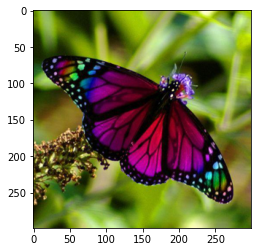

a person holding a frisbee in a field


In [ ]:
!wget https://100dorog.ru/upload/images/articles/2014/6572886-21-Babochki_i.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 10:01:24--  https://games.mail.ru/pre_0x736_resize/hotbox/content_files/news/2018/10/3b196c5.jpeg?quality=85
Resolving games.mail.ru (games.mail.ru)... 178.22.89.40
Connecting to games.mail.ru (games.mail.ru)|178.22.89.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54156 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  52.89K   298KB/s    in 0.2s    

2021-02-07 10:01:25 (298 KB/s) - ‘img.jpg’ saved [54156/54156]



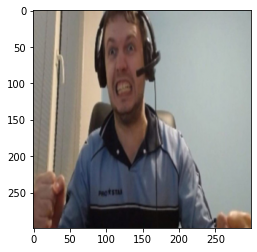

a man in a suit and tie standing in a room .


In [ ]:
!wget https://games.mail.ru/pre_0x736_resize/hotbox/content_files/news/2018/10/3b196c5.jpeg?quality=85 -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 10:01:28--  https://fantwitch.ru/wp-content/uploads/2019/03/2a14b95e6795.jpg
Resolving fantwitch.ru (fantwitch.ru)... 87.236.16.5
Connecting to fantwitch.ru (fantwitch.ru)|87.236.16.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25370 (25K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  24.78K  --.-KB/s    in 0s      

2021-02-07 10:01:29 (267 MB/s) - ‘img.jpg’ saved [25370/25370]



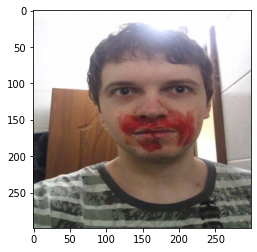

a little boy is holding a banana in his mouth .


In [ ]:
!wget https://fantwitch.ru/wp-content/uploads/2019/03/2a14b95e6795.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))

--2021-02-07 10:01:30--  https://i0.wp.com/arts-dnevnik.ru/wp-content/uploads/2017/11/7CF64A76-D4A9-4D0F-9A69-1F7E815E484B.jpeg
Resolving i0.wp.com (i0.wp.com)... 192.0.77.2
Connecting to i0.wp.com (i0.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258656 (253K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 252.59K  --.-KB/s    in 0.1s    

2021-02-07 10:01:30 (2.53 MB/s) - ‘img.jpg’ saved [258656/258656]



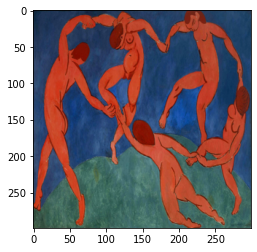

a group of people standing around a large green field .


In [ ]:
!wget https://i0.wp.com/arts-dnevnik.ru/wp-content/uploads/2017/11/7CF64A76-D4A9-4D0F-9A69-1F7E815E484B.jpeg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(img, t=5., device=device)[1:-1]))